In [14]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git
import sys, os
sys.path.append('/content/deep-learning-from-scratch-2')

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.


In [15]:
# !pip install cupy

In [16]:
import numpy as np

In [17]:
# Embedding 구현
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx] # 가중치W의 특정행만 추출
    return out
  
  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0 # dW형상을 유지한 채 그 원소들을 0으로 덮어씀
    for i, word_id in enumerate(self.idx):
      dW[word_id] += dout[i] # 먼저 쓰여진 값에 덮어써지는 중복문제를 해결
    return None

In [18]:
# Embedding Dot 구현
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx) # Embedding 계층의 foward(idx)를 호출
    out = np.sum(target_W * h, axis=1) # 내적계산
    self.cache = (h, target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)
    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

In [19]:
# UnigramSample 구현
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [20]:
# Negative Sampling Loss 구현
from common.config import GPU
from common.functions import softmax, cross_entropy_error
from common.layers import SigmoidWithLoss
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
    # 긍정적
    score = self.embed_dot_layers[0].forward(h, target) # forward 점수 계산
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label) #손실 계산
    # 부정적
    negative_label = np.zeros(batch_size, dtype=np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)
    return loss

  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)
    return dh

In [21]:
# CBOW 모델 구현
class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size

    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')

    # 계층생성
    self.in_layers = []
    for i in range(2*window_size):
      layer = Embedding(W_in) # Embedding 계층 생성
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

    # 모든 가중치와 기울기를 배열 모음
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1/len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout)
    dout *= 1/ len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 3001 / 9295 | 시간 115[s] | 손실 2.65
| 에폭 1 |  반복 6001 / 9295 | 시간 227[s] | 손실 2.40
| 에폭 1 |  반복 9001 / 9295 | 시간 340[s] | 손실 2.29
| 에폭 2 |  반복 1 / 9295 | 시간 351[s] | 손실 2.23
| 에폭 2 |  반복 3001 / 9295 | 시간 460[s] | 손실 2.16
| 에폭 2 |  반복 6001 / 9295 | 시간 570[s] | 손실 2.11
| 에폭 2 |  반복 9001 / 9295 | 시간 679[s] | 손실 2.06
| 에폭 3 |  반복 1 / 9295 | 시간 690[s] | 손실 2.03
| 에폭 3 |  반복 3001 / 9295 | 시간 800[s] | 손실 1.96
| 에폭 3 |  반복 6001 / 9295 | 시간 911[s] | 손실 1.95
| 에폭 3 |  반복 9001 / 9295 | 시간 1022[s] | 손실 1.92
| 에폭 4 |  반복 1 / 9295 | 시간 1033[s] | 손실 1.91
| 에폭 4 |  반복 3001 / 9295 | 시간 1142[s] | 손실 1.84
| 에폭 4 |  반복 6001 / 9295 | 시간 1250[s] | 손실 1.83
| 에폭 4 |  반복 9001 / 9295 | 시간 1358[s] | 손실 1.82
| 에폭 5 |  반복 1 / 9295 | 시간 1368[s] | 손실 1.81
| 에폭 5 |  반복 3001 / 9295 | 시간 1477[s] | 손실 1.75
| 에폭 5 |  반복 6001 / 9295 | 시간 1587[s] | 손실 1.75
| 에폭 5 |  반복 9001 / 9295 | 시간 1696[s] | 손실 1.74
| 에폭 6 |  반복 1 / 9295 | 시간 1707[s] | 손실 1.74
| 에폭 6 |  반복 3001 / 929

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

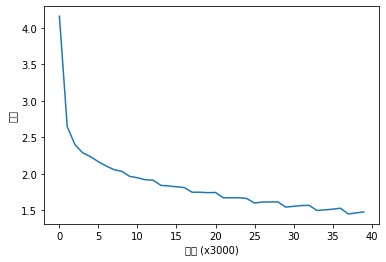

In [22]:
# model train
import pickle
from common import config
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

#config.GPU = True

# Hyperparameter
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# Data Read
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)

#if config.GPU:
#  contexts, target = to_gpu(contexts), to_gpu(target)

# Model
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# Train
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval = 3000)
trainer.plot()

# Data save
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file='cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

In [23]:
# Model eval
from common.util import most_similar

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.71630859375
 i: 0.6796875
 your: 0.5966796875
 someone: 0.57568359375
 they: 0.57373046875

[query] year
 month: 0.85400390625
 week: 0.77099609375
 spring: 0.76904296875
 summer: 0.74755859375
 decade: 0.66796875

[query] car
 luxury: 0.6181640625
 auto: 0.59375
 truck: 0.57958984375
 cars: 0.56982421875
 window: 0.56689453125

[query] toyota
 honda: 0.6376953125
 engines: 0.62841796875
 chevrolet: 0.625
 seita: 0.60498046875
 f-14: 0.6044921875


In [23]:
class SkipGram:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
      V, H = vocab_size, hidden_size
      rn = np.random.randn

      # 가중치 초기화
      W_in = 0.01 * rn(V, H).astype('f')
      W_out = 0.01 * rn(V, H).astype('f')

      # 계층 생성
      self.in_layer = Embedding(W_in)
      self.loss_layers = []
      for i in range(2 * window_size):
          layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
          self.loss_layers.append(layer)

      # 모든 가중치와 기울기를 배열모음.
      layers = [self.in_layer] + self.loss_layers
      self.params, self.grads = [], []
      for layer in layers:
          self.params += layer.params
          self.grads += layer.grads

      # 인스턴스 변수에 단어의 분산 표현을 저장
      self.word_vecs = W_in

  def forward(self, contexts, target):
      h = self.in_layer.forward(target)

      loss = 0
      for i, layer in enumerate(self.loss_layers):
          loss += layer.forward(h, contexts[:, i])
      return loss

  def backward(self, dout=1):
      dh = 0
      for i, layer in enumerate(self.loss_layers):
          dh += layer.backward(dout)
      self.in_layer.backward(dh)
      return None